In [1]:
def clustered_permutation_importance(clf,X,y,clusters,scoring, n_repeats): 
    """
    clf: fitted classifier
    X
    y
    clusters: (dict)
    scoring: 'acc','f1','auc'
    """
    from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

    scr_before, scr_after = pd.Series(), pd.DataFrame(columns=clusters.keys()) 
    for i in range(n_repeats):
        prob=clf.predict_proba(X)[:,1]
        pred=clf.predict(X)
        if scoring == 'auc':
            scr_before.loc[i]=roc_auc_score(y, prob)
        elif scoring == 'f1':
            scr_before.loc[i]=f1_score(y, pred)
        elif scoring == 'acc':
            scr_before.loc[i]=accuracy_score(y, pred)
            
        for  j  in  scr_after.columns:
            X_=X.copy(deep=True) 
            for  k  in  clusters[j]:
                np.random.shuffle(X_[k].values)  #  shufﬂe  cluster 
            prob2=clf.predict_proba(X_)[:,1]
            pred2=clf.predict(X_)
            if scoring == 'auc':
                scr_after.loc[i,j]=roc_auc_score(y, prob2)
            elif scoring == 'acc':
                scr_after.loc[i,j]=accuracy_score(y, pred2)
            elif scoring == 'f1':
                scr_after.loc[i,j]=f1_score(y, pred2)
    imp=(-1*scr_after).add(scr_before,axis=0)
    imp=imp/(1-scr_after).replace(0, np.nan)
    imp=pd.concat({'mean':imp.mean(),'std':imp.std()*imp.shape[0]**-.5},axis=1)
    imp.index = ['Cluster {}'.format(j) for j in scr_after.columns]
    imp.replace([-np.inf, np.nan], 0, inplace=True)
    return  imp

Feature Selection
- Input
    - label(y): 1,5,20 day price direction
    - periods : 2012-2022
    - features: TA, Net-purchase(SMA5),  Macro-variable(pct change)

- Model: RF (comparing with Logistic regression)
    - Feature Analysis Methods: 
        1. Feature clustering: Hierarchical Clustering - Spearman Correlation
        2. Permutation Importance (Accuracy, F1-score, AUC score) analysis

- Output
    - Performances
    - Feature cluster importance for each label and each score

In [2]:
# libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('tableau-colorblind10')

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Metrics
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score

# Feature Importance / Clustering
from sklearn.inspection import permutation_importance
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

In [3]:
import warnings
warnings.filterwarnings(action='ignore')

In [4]:
market_df = pd.read_csv('C:data/initial_data.csv')
market_df = market_df.rename(columns={market_df.columns[0]:'Date'})
market_df.index = pd.to_datetime(market_df.Date)
market_df.drop(columns='Date',inplace=True)
market_df.dropna(inplace=True)

feature_df = pd.read_csv('C:data/features.csv')
feature_df = feature_df.rename(columns={feature_df.columns[0]:'Date'})
feature_df.index = pd.to_datetime(feature_df.Date)
feature_df.drop(columns='Date',inplace=True)
feature_df.dropna(inplace=True)

In [11]:
X_ = feature_df.dropna()['2012':'2021']

In [12]:
# ADX
X_ =X_.drop(columns=['Trend ADX(14)', 'Trend ADX(28)'])

In [14]:
X_[:'2018']

,Trend DPO(20),Trend DPO(40),"Trend MACD (26,12)","Trend MACD (52,24)","Trend MACD_Diff (26,12,9)","Trend MACD_Diff (52,24,18)",Trend RSI(14),Trend RSI(28),Trend WR(14),Trend WR(28),...,institutions SMA5,individuals SMA5,foreigners SMA5,crude oil %Change,gold %Change,natural gas %Change,USD/KRW %Change,EUR/KRW %Change,JPY/KRW %Change,CNY/KRW %Change
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,-13.7645,61.09000,-4.619306,-4.589233,0.912873,-2.093932,54.302228,51.486401,-0.000000,-30.109755,...,1.651332e+11,-2.175586e+11,6.784662e+10,-0.008229,0.016819,-0.012554,-0.011689,-0.003479,-0.008205,-0.011727
2012-01-04,-74.9645,68.87300,-2.614976,-3.713112,2.333763,-1.089621,52.672905,50.802488,-13.774331,-35.255908,...,1.587162e+11,-2.541277e+11,1.063361e+11,0.041789,0.021650,0.001338,0.002313,-0.005786,0.002115,0.002252
2012-01-05,-56.0505,49.88775,-1.209287,-3.028187,2.991562,-0.362096,52.217574,50.614335,-15.623835,-36.644641,...,2.546007e+11,-3.371249e+11,9.191938e+10,0.002525,0.007626,0.034414,0.006705,-0.005779,-0.000080,0.005536
2012-01-06,2.7620,65.74050,-1.681656,-3.253423,2.015354,-0.525507,48.469497,49.049488,-30.986651,-48.180087,...,1.780933e+11,-2.565636e+11,7.972679e+10,-0.013660,0.004653,-0.037468,0.003849,-0.001056,0.006847,0.002671
2012-01-09,4.2550,59.63450,-3.311475,-4.121366,0.308428,-1.246772,45.619317,47.810512,-55.645855,-57.503640,...,1.035032e+11,-1.838823e+11,8.503692e+10,-0.002456,-0.002038,0.027517,-0.002111,0.001334,-0.000093,-0.002990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-21,-15.3885,-6.39275,-8.768239,-28.691267,-0.729344,5.702778,44.366078,43.559879,-78.677243,-80.455469,...,2.664382e+11,-1.863675e+11,-7.275439e+10,-0.027966,0.009185,-0.038379,0.005575,-0.000879,0.006115,0.002453
2018-12-24,-6.9180,-20.33675,-9.453939,-28.612437,-1.132036,5.173018,42.919450,42.900785,-81.699752,-87.383727,...,2.754721e+11,-1.882196e+11,-8.447854e+10,-0.006321,-0.007756,0.065029,-0.003693,-0.001324,0.003300,-0.002630
2018-12-26,-25.3175,4.87025,-11.954558,-29.554169,-2.906124,3.785887,37.441342,40.268068,-84.769828,-88.788176,...,2.885200e+11,-2.514069e+11,-3.886758e+10,-0.067120,0.010927,-0.091457,-0.001076,-0.005147,-0.009279,0.000920


In [15]:
X_['2019':]

,Trend DPO(20),Trend DPO(40),"Trend MACD (26,12)","Trend MACD (52,24)","Trend MACD_Diff (26,12,9)","Trend MACD_Diff (52,24,18)",Trend RSI(14),Trend RSI(28),Trend WR(14),Trend WR(28),...,institutions SMA5,individuals SMA5,foreigners SMA5,crude oil %Change,gold %Change,natural gas %Change,USD/KRW %Change,EUR/KRW %Change,JPY/KRW %Change,CNY/KRW %Change
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,28.4275,37.71700,-16.413802,-31.502712,-4.501905,1.099988,35.525636,39.126064,-94.279153,-95.674492,...,-7.669407e+10,-3.260253e+10,9.643442e+10,0.001765,-0.001250,-0.109900,0.005223,-0.005899,0.011633,0.007654
2019-01-03,9.1690,22.55750,-19.366083,-33.126642,-5.963348,-0.468791,32.814675,37.672457,-98.182302,-98.587084,...,-1.601935e+11,3.322364e+10,1.155567e+11,0.024884,0.002112,0.006122,0.005151,0.009625,0.016496,0.003676
2019-01-04,16.0840,59.61175,-20.169745,-33.783163,-5.413608,-1.006858,37.988907,40.018848,-78.548791,-83.102293,...,-1.907418e+11,1.065415e+11,7.945738e+10,0.011818,0.008431,-0.004395,-0.008029,-0.007943,-0.015931,-0.007629
2019-01-07,10.3145,43.07150,-18.493377,-33.162430,-2.989792,-0.345480,45.343286,43.591615,-52.686527,-65.462190,...,-4.864617e+10,5.530315e+09,4.222412e+10,0.018475,-0.007045,0.033616,0.000725,0.007803,-0.000981,0.003383
2019-01-08,29.2155,31.71550,-17.875168,-32.992191,-1.897267,-0.156794,42.927611,42.436658,-57.615481,-73.234347,...,-1.771234e+10,1.907752e+10,-3.417134e+09,0.011676,0.003196,-0.032851,0.004626,0.001684,0.004358,0.004291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,30.3760,21.06425,4.058713,-14.025110,1.187629,10.093647,52.688852,49.690307,-41.009520,-20.651289,...,1.306086e+11,-2.818863e+11,1.297798e+11,0.023060,0.007663,0.027656,-0.003915,-0.003561,-0.006529,-0.004014
2021-12-27,30.4950,-38.34475,5.870833,-11.241411,1.951957,10.407688,52.501453,49.776638,-50.358240,-20.027137,...,5.188255e+11,-7.289797e+11,1.818872e+11,0.014156,0.005329,-0.061620,0.000051,-0.000112,-0.003937,-0.000107
2021-12-28,12.8635,-65.63350,7.549678,-9.436214,2.904641,10.927318,56.021675,51.511137,-26.828159,-10.669380,...,7.022412e+11,-9.989736e+11,2.658021e+11,0.024122,-0.001712,0.088180,0.002092,0.000573,0.002335,0.002526


In [16]:
X_stats = X_.describe().T
X_stats = X_stats[['mean','std','50%','min','max','count']].round(2)
X_stats.to_excel('c:data/x_stats.xlsx')
X_stats

,mean,std,50%,min,max,count
Trend DPO(20),-6.100000e-01,2.877000e+01,1.900000e-01,-2.545000e+02,1.884200e+02,2386.0
Trend DPO(40),-7.500000e-01,3.931000e+01,1.370000e+00,-3.728100e+02,1.697000e+02,2386.0
"Trend MACD (26,12)",2.930000e+00,2.332000e+01,3.200000e+00,-1.535900e+02,1.203500e+02,2386.0
"Trend MACD (52,24)",6.040000e+00,3.267000e+01,5.490000e+00,-1.365600e+02,1.590900e+02,2386.0
"Trend MACD_Diff (26,12,9)",-2.000000e-02,6.960000e+00,4.000000e-02,-4.726000e+01,3.468000e+01,2386.0
"Trend MACD_Diff (52,24,18)",-8.000000e-02,1.057000e+01,2.800000e-01,-6.987000e+01,3.602000e+01,2386.0
Trend RSI(14),5.216000e+01,1.216000e+01,5.239000e+01,1.215000e+01,8.625000e+01,2386.0
Trend RSI(28),5.174000e+01,8.450000e+00,5.191000e+01,2.031000e+01,7.957000e+01,2386.0
Trend WR(14),-4.290000e+01,3.124000e+01,-3.878000e+01,-1.000000e+02,-0.000000e+00,2386.0
Trend WR(28),-4.184000e+01,3.047000e+01,-3.824000e+01,-1.000000e+02,-0.000000e+00,2386.0


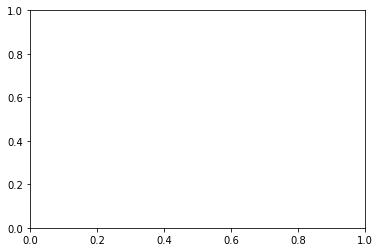

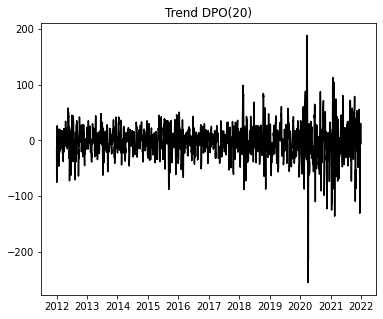

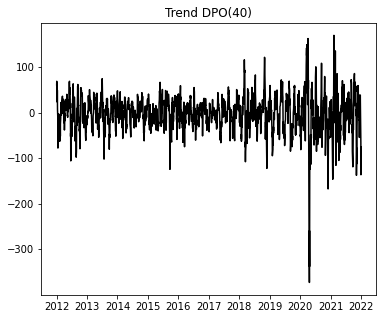

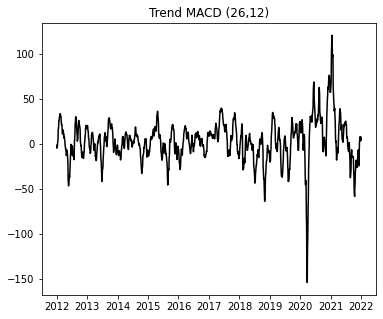

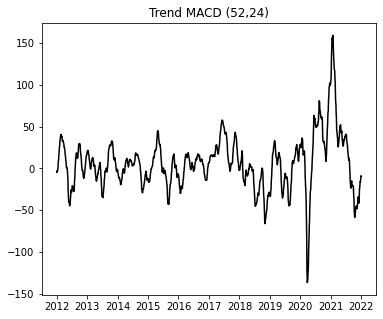

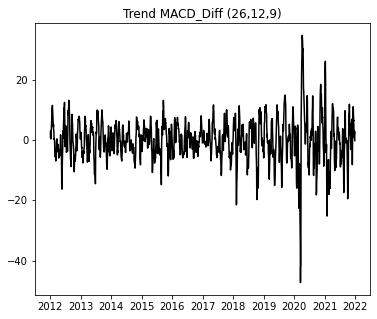

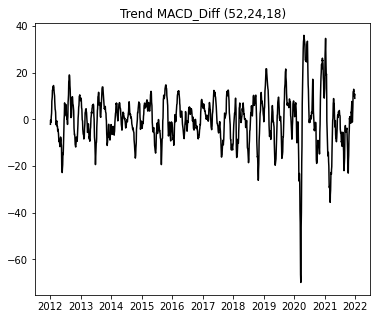

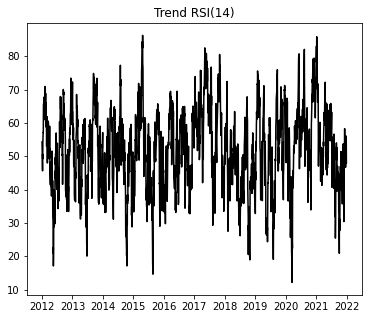

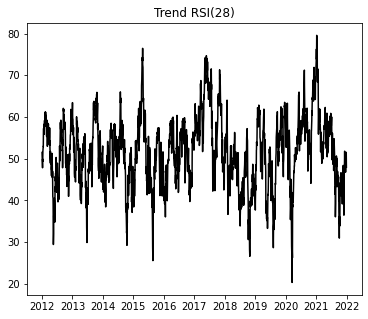

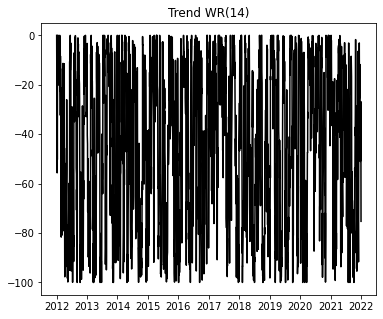

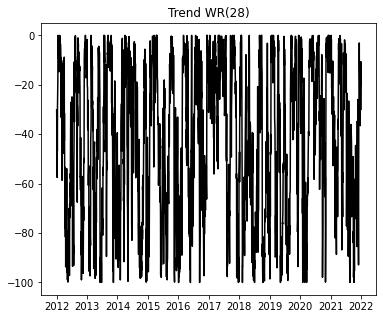

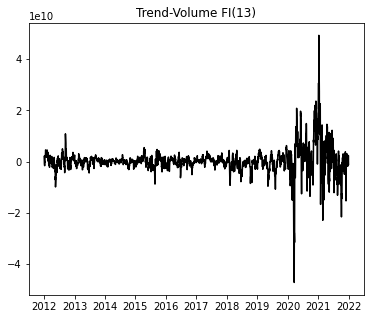

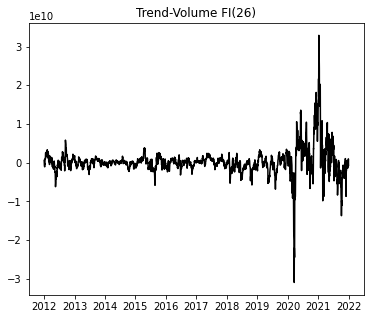

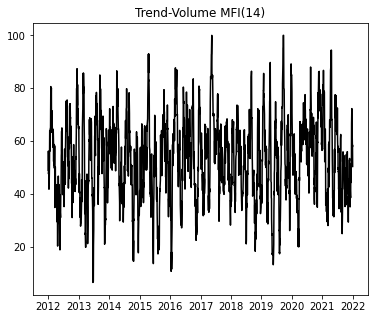

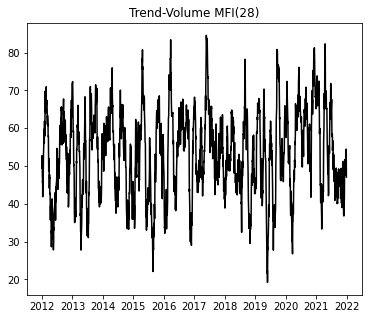

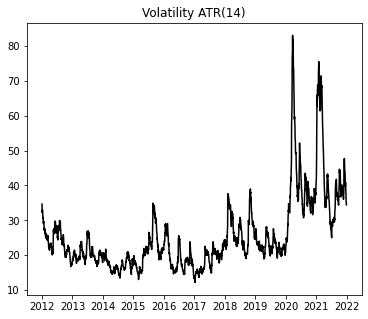

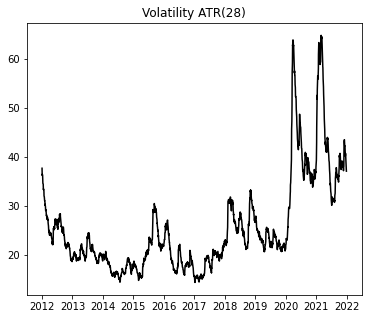

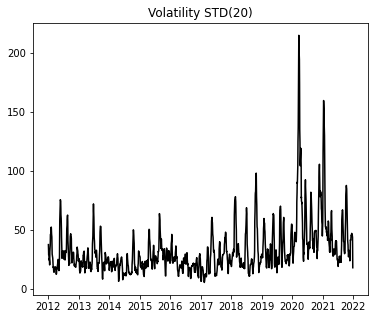

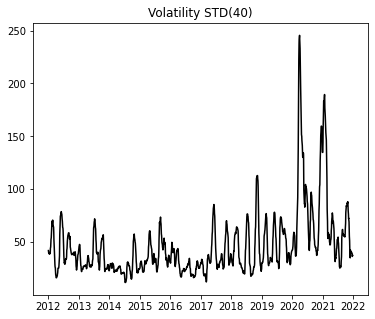

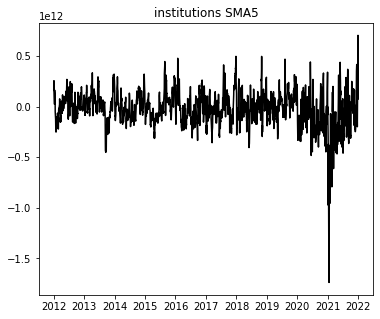

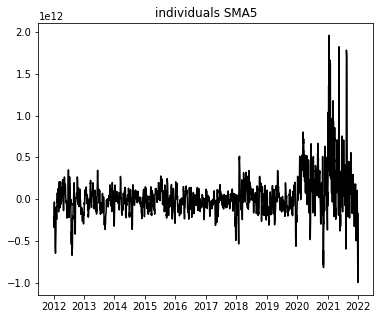

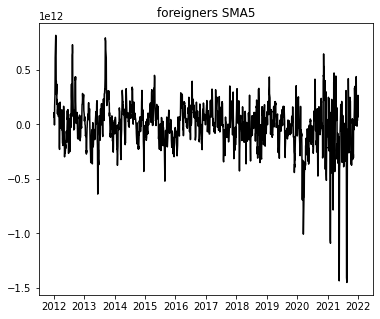

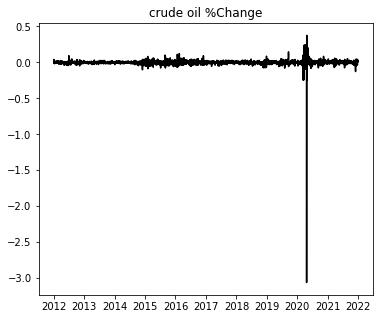

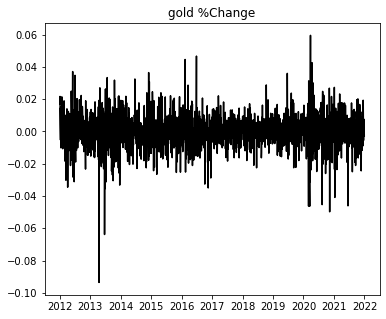

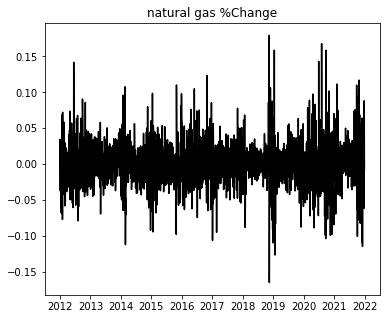

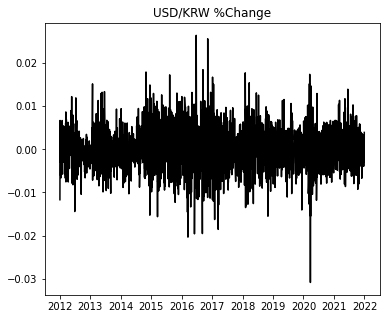

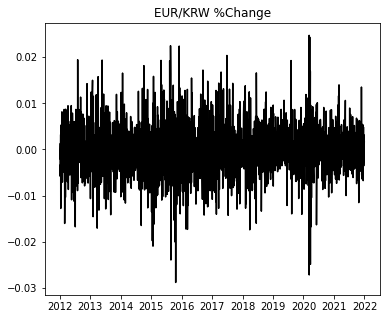

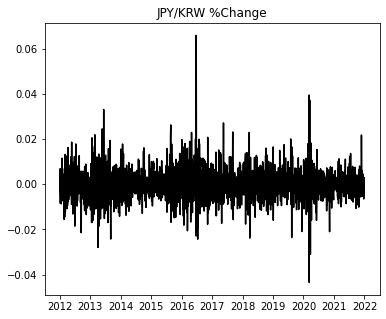

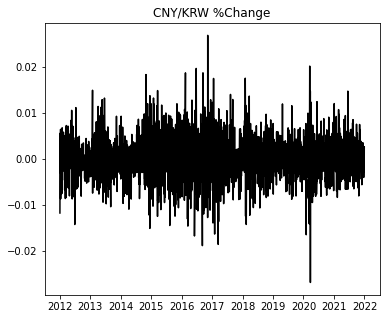

In [17]:
plt.subplots()
for i in X_.columns:
    plt.figure(figsize=(6,5))
    plt.title(i)
    plt.plot(X_[i], color='black')
    plt.xticks()
    plt.show()

# Feature Importance

In [18]:
from sklearn.preprocessing import StandardScaler

def feature_scaler(X):
    X_sc = StandardScaler().fit_transform(X)
    X_sc = pd.DataFrame(X_sc, index=X.index, columns=X.columns)
    return X_sc

def feature_scaler_test(X_train, X_test):
    scaler = StandardScaler()
    X_sc_train = scaler.fit_transform(X_train)
    X_sc_test = scaler.transform(X_test)
    X_sc_test = pd.DataFrame(X_sc_test, index=X_test.index, columns=X_test.columns)
    return X_sc_test

Clustering

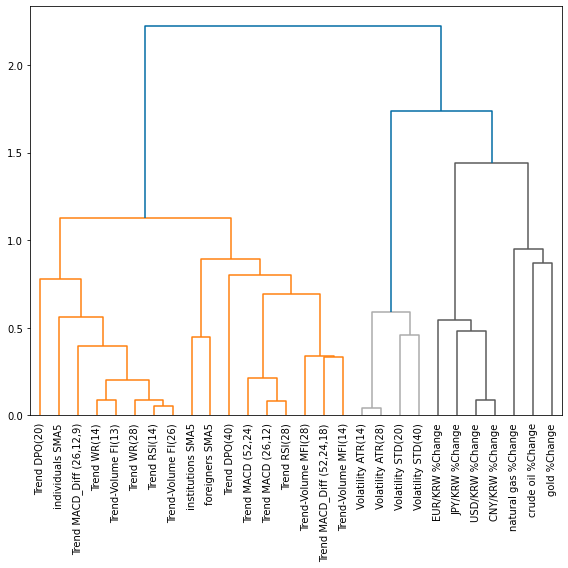

In [19]:
fig, ax = plt.subplots(1, figsize=(8, 8))
corr = spearmanr(X_['2012':'2019']).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X_.columns, ax=ax, leaf_rotation=90
)
fig.tight_layout()
plt.savefig('c:img/hier_dendogram.png')
plt.show()

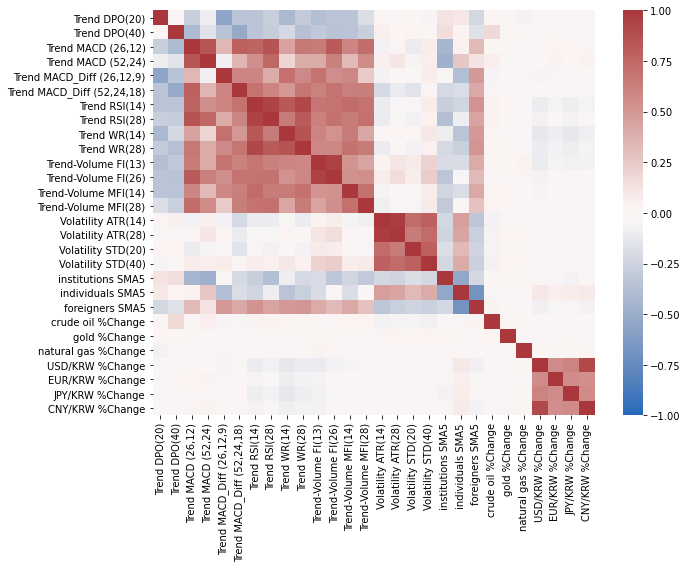

In [20]:
plt.figure(figsize=(10,8))
sns.heatmap(X_.corr(), vmin=-1,vmax=1, cmap='vlag')
plt.tight_layout()
plt.savefig('c:img/corr.png')
plt.show()

In [21]:
from collections import defaultdict
cluster_ids = hierarchy.fcluster(dist_linkage, 1.1, criterion="distance")
clusters_ = {i: X_.columns[np.where(cluster_ids == i)[0]].tolist() for i in np.unique(cluster_ids)}
#clusters = [clusters_[i] for i in range(1,1+len(clusters_))]

In [22]:
clusters_

{1: ['Trend DPO(20)',
  'Trend MACD_Diff (26,12,9)',
  'Trend RSI(14)',
  'Trend WR(14)',
  'Trend WR(28)',
  'Trend-Volume FI(13)',
  'Trend-Volume FI(26)',
  'individuals SMA5'],
 2: ['Trend DPO(40)',
  'Trend MACD (26,12)',
  'Trend MACD (52,24)',
  'Trend MACD_Diff (52,24,18)',
  'Trend RSI(28)',
  'Trend-Volume MFI(14)',
  'Trend-Volume MFI(28)',
  'institutions SMA5',
  'foreigners SMA5'],
 3: ['Volatility ATR(14)',
  'Volatility ATR(28)',
  'Volatility STD(20)',
  'Volatility STD(40)'],
 4: ['USD/KRW %Change',
  'EUR/KRW %Change',
  'JPY/KRW %Change',
  'CNY/KRW %Change'],
 5: ['crude oil %Change', 'gold %Change', 'natural gas %Change']}

In [23]:
def simple_train_test_split(X_,y_,start_date, split_date, end_date):
    tmp = pd.concat([X_,y_],axis=1).dropna()
    X = tmp.iloc[:,:-1]; y = tmp.iloc[:,-1].rename('y')
    X_train = X[start_date:split_date]; y_train = y[start_date:split_date]
    X_test = X[split_date:end_date]; y_test = y[split_date:end_date]; 
    return X_train, y_train, X_test, y_test

In [24]:
n_estimators = [20,50,100] # number of trees in the random forest
max_depth = [3,9,15] # maximum number of levels allowed in each decision tree

param_grid = {'n_estimators': n_estimators,
'max_depth': max_depth}
from sklearn.model_selection import GridSearchCV
rf = RandomForestClassifier()
gcv = GridSearchCV(rf,param_grid=param_grid)
best_params = []
best_rf = []

price = market_df.close['2012':]
periods = [1,5,20]
y_list = [np.sign(np.sign(-price.diff(-y_))+1).rename('y_{}'.format(y_)) for y_ in periods]

for y_i in y_list:
    gcv = GridSearchCV(rf,param_grid=param_grid)
    tmp = pd.concat([X_,y_i],axis=1).dropna()
    X = tmp.iloc[:,:-1]; y = tmp.iloc[:,-1].rename('y')
    X = feature_scaler(X)
    gcv.fit(X, y)
    best_params.append(gcv.best_params_)
    best_rf.append(gcv.best_estimator_)

In [25]:
best_params

[{'max_depth': 3, 'n_estimators': 20},
 {'max_depth': 3, 'n_estimators': 20},
 {'max_depth': 3, 'n_estimators': 50}]

In [46]:
# SIMPLE TRAIN_TEST
rfy1=RandomForestClassifier(max_depth=3, n_estimators=100)
rfy5=RandomForestClassifier(max_depth=3, n_estimators=100)
rfy20=RandomForestClassifier(max_depth=15, n_estimators=50)

# Models
lr = LogisticRegression()
#rfy1=best_rf[0]
#rfy5=best_rf[1]
#rfy20=best_rf[2]
#rfy60=best_rf[3]
clf_list = [[lr,rfy1],[lr,rfy5],[lr,rfy20]]
estimators=['LR','RF']

#labeling
price = market_df.close['2012':]
periods = [1,5,20]
y_list = [np.sign(np.sign(-price.diff(-y_))+1).rename('y_{}'.format(y_)) for y_ in periods]

In [50]:
results_list=[]

for i in range(len(y_list)):
    y_i = y_list[i]
    X_train_, y_train, X_test_, y_test = simple_train_test_split(X_,y_i,'2012','2019','2022')
    X_train = feature_scaler(X_train_)
    X_test = feature_scaler_test(X_train_, X_test_)
    scores_list = []
    for clf in clf_list[i]:
        y_preds_ = []
        y_probs_ = []
        clf.fit(X_train, y_train)
        y_true = y_test
        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)[:,1]
        
        accs = accuracy_score(y_true, y_pred)
        f1=f1_score(y_true, y_pred)
        #prec=precision_score(y_true, y_pred)
        rocauc = roc_auc_score(y_true, y_prob)
        score = [accs, f1, rocauc]
        scores_list.append(score)
        
    results = pd.DataFrame(scores_list, columns=['accuracy','f1 score','roc auc score'],
                           index=estimators)
    results_list.append(results)

In [51]:
results_list

[    accuracy  f1 score  roc auc score
 LR  0.552011  0.566443       0.558798
 RF  0.596394  0.686084       0.610713,
     accuracy  f1 score  roc auc score
 LR  0.493759  0.507422       0.499764
 RF  0.629681  0.747398       0.609564,
     accuracy  f1 score  roc auc score
 LR  0.452150  0.447552       0.448130
 RF  0.697642  0.766595       0.785045]

In [52]:
results_df = pd.concat(results_list)
index_array = [np.sort(np.array(['$y_{001}$','$y_{005}$','$y_{020}$']*len(estimators))),np.array(results_df.index.values)]
results_df.index = index_array
results_df.round(4).to_excel('c:data/model_performance.xlsx')
results_df.round(4)

accuracy  f1 score  roc auc score
$y_{001}$ LR    0.5520    0.5664         0.5588
          RF    0.5964    0.6861         0.6107
$y_{005}$ LR    0.4938    0.5074         0.4998
          RF    0.6297    0.7474         0.6096
$y_{020}$ LR    0.4521    0.4476         0.4481
          RF    0.6976    0.7666         0.7850

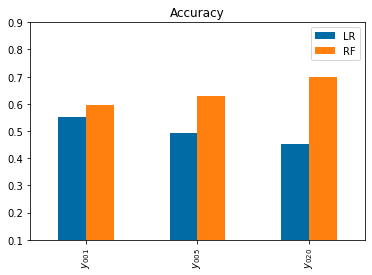

In [53]:
results_df.unstack()['accuracy'].plot(kind='bar')
plt.title('Accuracy')
plt.ylim(.1,.9)
plt.savefig('C:img/accuracy.png')

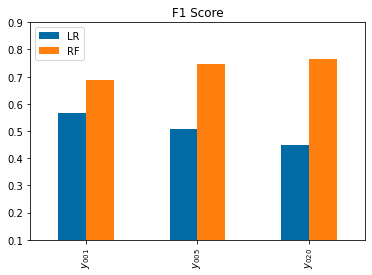

In [54]:
results_df.unstack()['f1 score'].plot(kind='bar')
plt.title('F1 Score')
plt.ylim(0.1,0.9)
plt.savefig('C:img/f1.png')

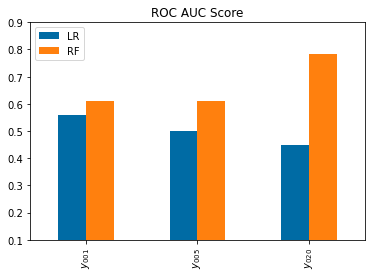

In [55]:
results_df.unstack()['roc auc score'].plot(kind='bar')
plt.title('ROC AUC Score')
plt.ylim(0.1,0.9)
plt.savefig('C:img/rocauc.png')

## Clustered Permutation Importance

aka. Mean Decrease Accuracy , Mean Decrease F1, Mean Decrease AUC

In [33]:
results_list=[]
importance_list_acc = []
importance_list_f1 = []
importance_list_auc = []

for i in range(len(y_list)):
    y_i = y_list[i]
    X_train_, y_train, X_test_, y_test = simple_train_test_split(X_,y_i,'2012','2018','2022')
    X_train = feature_scaler(X_train_)
    X_test = feature_scaler_test(X_train_, X_test_)
    scores_list = []
    importance_clf_acc = []
    importance_clf_f1 = []
    importance_clf_auc = []
    for clf in clf_list[i]:
        y_preds_ = []
        y_probs_ = []
        clf.fit(X_train, y_train)
        y_true = y_test
        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)[:,1]
        accs = accuracy_score(y_true, y_pred)
        f1=f1_score(y_true, y_pred)
        prec=precision_score(y_true, y_pred)
        rocauc = roc_auc_score(y_true, y_prob)
        score = [accs, f1, prec, rocauc]
        scores_list.append(score)
        result_imp_acc = clustered_permutation_importance(clf, X_test, y_test, clusters_, 'acc',10)
        result_imp_f1 = clustered_permutation_importance(clf, X_test, y_test, clusters_, 'f1',10)
        result_imp_auc = clustered_permutation_importance(clf, X_test, y_test, clusters_, 'auc',10)
        importance_clf_acc.append(result_imp_acc)
        importance_clf_f1.append(result_imp_f1)
        importance_clf_auc.append(result_imp_auc)
        
    results = pd.DataFrame(scores_list, columns=['accuracy','f1 score','precision score','roc auc score'],
                           index=estimators)
    results_list.append(results)
    importance_list_acc.append(importance_clf_acc)
    importance_list_f1.append(importance_clf_f1)
    importance_list_auc.append(importance_clf_auc)

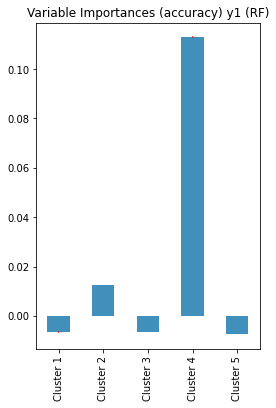

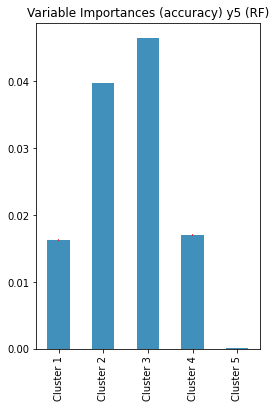

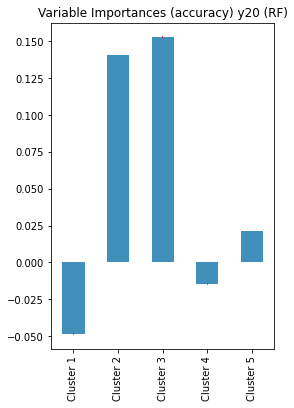

In [34]:
importance_df_acc = []
for j in range(len(y_list)):
    for i in range(len(estimators)-1):
        importance_df = importance_list_acc[j][i+1]
        plt.figure(figsize=(4, 6))
        #importance_df.sort_values('mean', ascending=True, inplace=True)
        importance_df['mean'].plot(kind='bar', alpha=0.75, xerr=importance_df['std'], error_kw={'ecolor': 'r'})
        importance_df_acc.append(importance_df)
        plt.title("Variable Importances (accuracy) y{} ({})".format(periods[j], estimators[i+1]))
        plt.savefig('C:img/imp_y{}_{}.png'.format(periods[j], estimators[i+1]))

In [35]:
importance_df_acc

[               mean       std
 Cluster 1 -0.006578  0.005804
 Cluster 2  0.012620  0.004459
 Cluster 3 -0.006683  0.004220
 Cluster 4  0.112810  0.006398
 Cluster 5 -0.007341  0.002521,
                mean       std
 Cluster 1  0.016223  0.004775
 Cluster 2  0.039818  0.002297
 Cluster 3  0.046479  0.003784
 Cluster 4  0.017074  0.002791
 Cluster 5  0.000190  0.002485,
                mean       std
 Cluster 1 -0.048484  0.011392
 Cluster 2  0.140799  0.010405
 Cluster 3  0.152552  0.008249
 Cluster 4 -0.014709  0.005383
 Cluster 5  0.021516  0.002860]

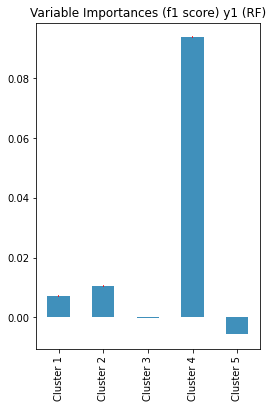

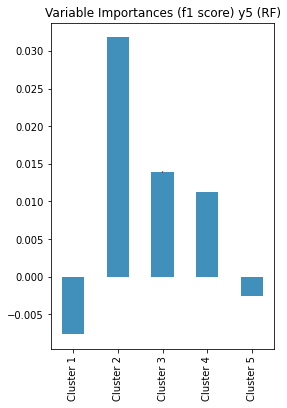

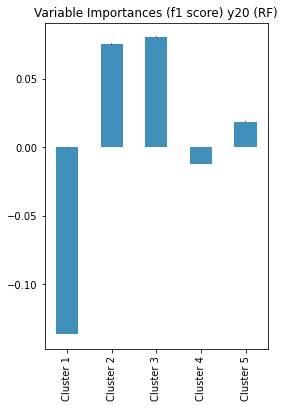

In [36]:
importance_df_f1=[]
for j in range(len(y_list)):
    for i in range(len(estimators)-1):
        importance_df = importance_list_f1[j][i+1]
        plt.figure(figsize=(4, 6))
        #importance_df.sort_values('mean', ascending=True, inplace=True)
        importance_df['mean'].plot(kind='bar', alpha=0.75, xerr=importance_df['std'], error_kw={'ecolor': 'r'})
        importance_df_f1.append(importance_df)
        plt.title("Variable Importances (f1 score) y{} ({})".format(periods[j], estimators[i+1]))
        plt.savefig('C:img/imp_f1_y{}_{}.png'.format(periods[j], estimators[i+1]))

In [37]:
importance_df_f1

[               mean       std
 Cluster 1  0.007323  0.007996
 Cluster 2  0.010587  0.006169
 Cluster 3 -0.000266  0.004177
 Cluster 4  0.093644  0.007111
 Cluster 5 -0.005534  0.003724,
                mean       std
 Cluster 1 -0.007595  0.005069
 Cluster 2  0.031778  0.006967
 Cluster 3  0.013914  0.002925
 Cluster 4  0.011213  0.002584
 Cluster 5 -0.002554  0.002636,
                mean       std
 Cluster 1 -0.136097  0.007748
 Cluster 2  0.075380  0.007997
 Cluster 3  0.079953  0.005425
 Cluster 4 -0.012309  0.005236
 Cluster 5  0.018286  0.004141]

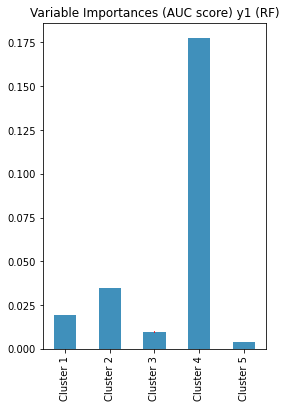

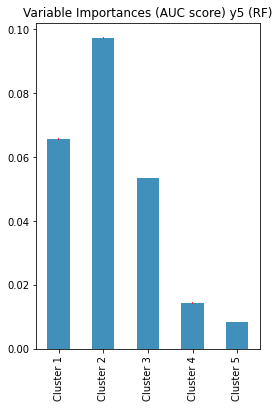

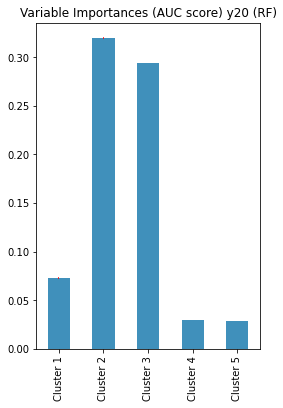

In [38]:
importance_df_auc=[]
for j in range(len(y_list)):
    for i in range(len(estimators)-1):
        importance_df = importance_list_auc[j][i+1]
        plt.figure(figsize=(4, 6))
        #importance_df.sort_values('mean', ascending=True, inplace=True)
        importance_df['mean'].plot(kind='bar', alpha=0.75, xerr=importance_df['std'], error_kw={'ecolor': 'r'})
        importance_df_auc.append(importance_df)
        plt.title("Variable Importances (AUC score) y{} ({})".format(periods[j], estimators[i+1]))
        plt.savefig('C:img/imp_auc_y{}_{}.png'.format(periods[j], estimators[i+1]))

In [39]:
importance_df_auc

[               mean       std
 Cluster 1  0.019210  0.006800
 Cluster 2  0.034850  0.003043
 Cluster 3  0.009774  0.002310
 Cluster 4  0.177450  0.005843
 Cluster 5  0.003961  0.001271,
                mean       std
 Cluster 1  0.065690  0.005420
 Cluster 2  0.097240  0.006625
 Cluster 3  0.053443  0.006817
 Cluster 4  0.014244  0.001562
 Cluster 5  0.008371  0.001621,
                mean       std
 Cluster 1  0.072315  0.006890
 Cluster 2  0.319364  0.007288
 Cluster 3  0.293650  0.005744
 Cluster 4  0.029339  0.003269
 Cluster 5  0.028128  0.002607]